In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit import transpile
sim = QasmSimulator() # making new simulator object

# Loading the IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


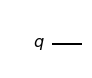

In [2]:
from qiskit import QuantumCircuit

mycircuit = QuantumCircuit(1)
mycircuit.draw('mpl')

In [3]:
from qiskit.quantum_info import Statevector

sv = Statevector.from_label('0')

sv

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [4]:
sv.data

array([1.+0.j, 0.+0.j])

In [5]:
new_sv = sv.evolve(mycircuit)

new_sv

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [6]:
#computing the projection of new_sv onto sv projection

from qiskit.quantum_info import state_fidelity

state_fidelity(sv, new_sv)

1.0

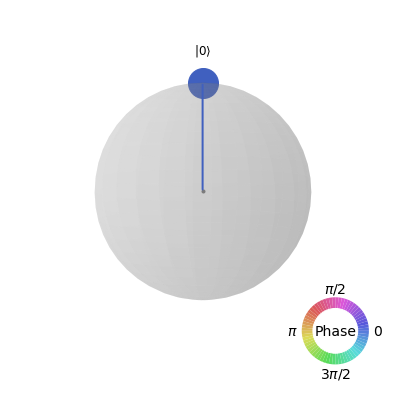

In [7]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(sv)

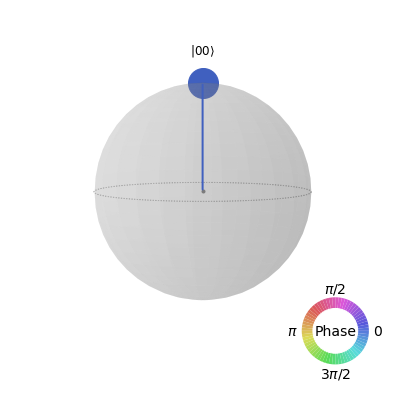

In [5]:
sv = Statevector.from_label('00')
plot_state_qsphere(sv.data)

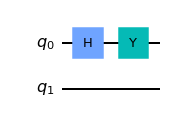

In [6]:
mycircuit = QuantumCircuit(2)
#mycircuit.x([0,1])
mycircuit.h(0)
mycircuit.y(0)
mycircuit.draw('mpl')

Statevector([0.-0.70710678j, 0.+0.70710678j, 0.+0.j        ,
             0.+0.j        ],
            dims=(2, 2))


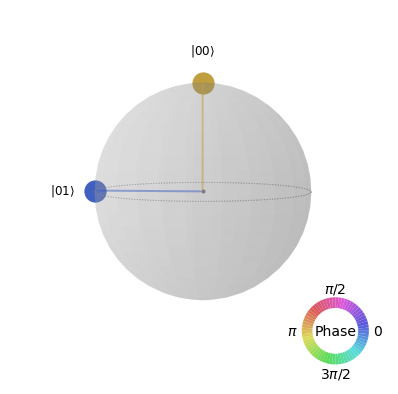

In [7]:
new_sv = sv.evolve(mycircuit)
print(new_sv)
plot_state_qsphere(new_sv.data)

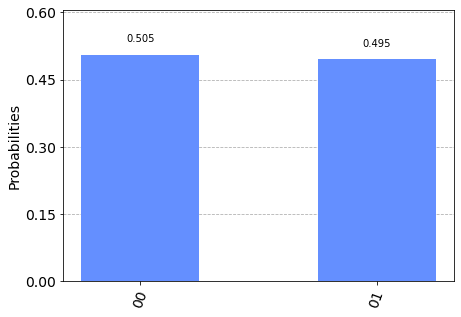

In [8]:
counts = new_sv.sample_counts(shots=1000)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

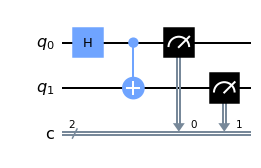

In [12]:
mycircuit = QuantumCircuit(2, 2)
mycircuit.h(0)
mycircuit.cx(0,1)
mycircuit.measure([0,1], [0,1])
mycircuit.draw('mpl')

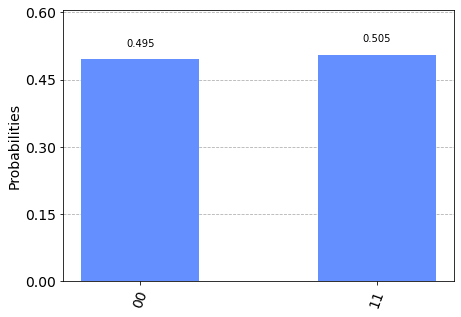

In [13]:
#need to use a simulator to run the circuit as this has non-unitary measurement gates

from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(mycircuit, simulator, shots=10000).result()
counts = result.get_counts(mycircuit)
plot_histogram(counts)

Let's try to teleport the quantum state 
$$\sqrt{0.70}\vert0\rangle + \sqrt{0.30}\vert1\rangle$$ from Alice's qubit to Bob's qubit. 

The teleportation algorithm consists of four major components:

1. Initializing the state to be teleported. We will do this on Alice's qubit `q0`.
2. Creating entanglement between two qubits. We will use qubits `q1` and `q2` for this. Recall that Alice owns `q1`, and Bob owns `q2`.
3. Applying a Bell measurement on Alice's qubits `q0` and `q1`.
4. Applying classically controlled operations on Bob's qubit `q2` depending on the outcomes of the Bell measurement on Alice's qubits.

In [14]:
def initialize_qubit(given_circuit, qubit_index):

    given_circuit.initialize([np.sqrt(0.7), np.sqrt(0.3)], qubit_index)
    
    return given_circuit

In [15]:
def entangle_qubits(given_circuit, qubit_Alice, qubit_Bob):
    
    given_circuit.h(qubit_Alice)
    given_circuit.cx(qubit_Alice, qubit_Bob)
    
    return given_circuit

In [16]:
def bell_meas_Alice_qubits(given_circuit, qubit1_Alice, qubit2_Alice, clbit1_Alice, clbit2_Alice):
    
    given_circuit.cx(qubit1_Alice, qubit2_Alice)
    given_circuit.h(qubit1_Alice)
    given_circuit.barrier()
    given_circuit.measure(qubit1_Alice, clbit1_Alice)
    given_circuit.measure(qubit2_Alice, clbit2_Alice)

    return given_circuit

In [39]:
def controlled_ops_Bob_qubit(given_circuit, qubit_Bob, clbit1_Alice, clbit2_Alice):
    
    given_circuit.x(qubit_Bob).c_if(clbit2_Alice, 1)
    given_circuit.z(qubit_Bob).c_if(clbit1_Alice, 1)       
    
    return given_circuit

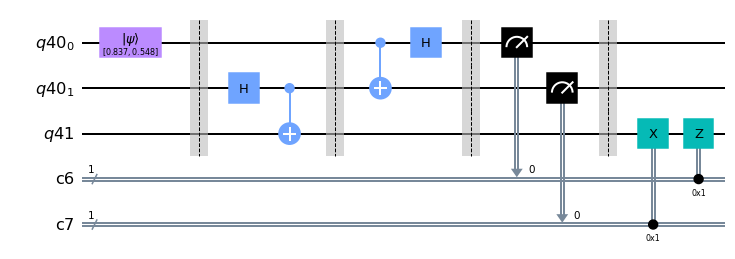

In [40]:
### imports
from qiskit import QuantumRegister, ClassicalRegister

### set up the qubits and classical bits
all_qubits_Alice = QuantumRegister(2)
all_qubits_Bob = QuantumRegister(1)
creg1_Alice = ClassicalRegister(1)
creg2_Alice = ClassicalRegister(1)

### quantum teleportation circuit here
# Initialize
mycircuit = QuantumCircuit(all_qubits_Alice, all_qubits_Bob, creg1_Alice, creg2_Alice)
initialize_qubit(mycircuit, 0)
mycircuit.barrier()
# Entangle
entangle_qubits(mycircuit, 1, 2)
mycircuit.barrier()
# Do a Bell measurement
bell_meas_Alice_qubits(mycircuit, all_qubits_Alice[0], all_qubits_Alice[1], creg1_Alice, creg2_Alice)
mycircuit.barrier()
# Apply classically controlled quantum gates
controlled_ops_Bob_qubit(mycircuit, all_qubits_Bob[0], creg1_Alice, creg2_Alice)

### Look at the complete circuit
mycircuit.draw()